In [1]:
import torch
from matplotlib import pyplot as plt

from lafomo.utilities.torch import inv_softplus, softplus
from lafomo.datasets import DeterministicLotkaVolterra
from lafomo.plot import Plotter, plot_phase, Colours
from experiments.lotka import build_lotka, plot_lotka
import numpy as np

f64 = np.float64

In [2]:
Colours.bar2_color

(0.00784313725490196, 0.6196078431372549, 0.45098039215686275)

Lotka-Voltera is in greek mode.
Creating dataset...


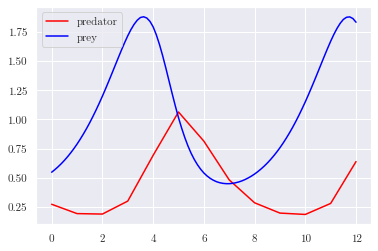

In [3]:
dataset = DeterministicLotkaVolterra(
    alpha = 2./3,
    beta = 4./3,
    gamma = 1.,
    delta = 1.,
    steps=13,
    end_time=12
)
x_min, x_max = min(dataset.times), max(dataset.times)

plt.plot(dataset.data[0][0], dataset.data[0][1], c='red', label='predator')
plt.plot(torch.linspace(x_min, x_max, dataset.prey.shape[0]), dataset.prey, c='blue', label='prey')
plt.legend()
num_latents = 1
num_outputs = 1
num_training = dataset[0][0].shape[0]

In [4]:
params = dict(
    natural=False,
    kernel='rbf'
)
lfm, trainer, plotter = build_lotka(dataset, params)

Num training points:  13
torch.Size([70, 1, 33])


/Users/jacob/Documents/proj/reggae/lafomo/models/variational_lfm.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.initial_conditions = Parameter(torch.tensor(torch.zeros(self.num_outputs, 1)), requires_grad=True)


In [16]:
trainer.train(400, report_interval=10, step_size=1e-1)

Epoch 401/800 - Loss: 1.03 (0.92 0.11) kernel: [[[1.9088328]]]
Epoch 411/800 - Loss: 1.02 (0.91 0.11) kernel: [[[1.9088326]]]
Epoch 421/800 - Loss: 1.02 (0.91 0.11) kernel: [[[1.9088317]]]
Epoch 431/800 - Loss: 1.02 (0.91 0.11) kernel: [[[1.9088309]]]
Epoch 441/800 - Loss: 1.01 (0.90 0.11) kernel: [[[1.90883]]]
Epoch 451/800 - Loss: 1.01 (0.90 0.11) kernel: [[[1.9088291]]]
Epoch 461/800 - Loss: 1.01 (0.90 0.11) kernel: [[[1.9088283]]]
Epoch 471/800 - Loss: 1.00 (0.90 0.11) kernel: [[[1.9088274]]]
Epoch 481/800 - Loss: 1.00 (0.89 0.10) kernel: [[[1.9088266]]]
Epoch 491/800 - Loss: 0.99 (0.89 0.10) kernel: [[[1.9088256]]]
Epoch 501/800 - Loss: 0.99 (0.89 0.10) kernel: [[[1.9088248]]]
Epoch 511/800 - Loss: 0.99 (0.89 0.10) kernel: [[[1.908824]]]
Epoch 521/800 - Loss: 0.98 (0.88 0.10) kernel: [[[1.908823]]]
Epoch 531/800 - Loss: 0.98 (0.88 0.10) kernel: [[[1.9088221]]]
Epoch 541/800 - Loss: 0.98 (0.88 0.10) kernel: [[[1.9088213]]]
Epoch 551/800 - Loss: 0.97 (0.87 0.10) kernel: [[[1.9088204

'cmunrm.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'cmunrm.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'cmunrm.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


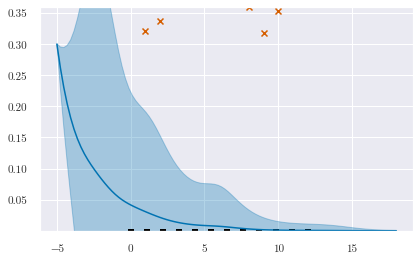

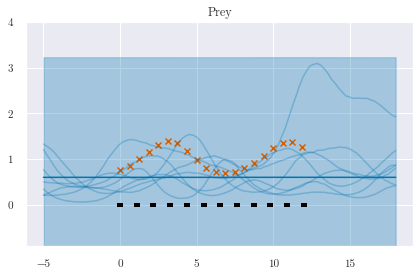

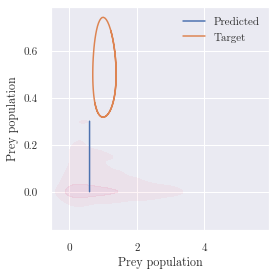

In [25]:
from pathlib import Path
plot_lotka(dataset, lfm, trainer, plotter, Path('./'), params)

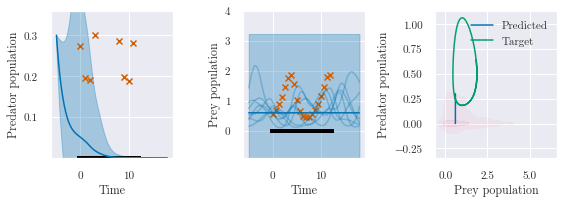

In [5]:
lfm.eval()
t_predict = torch.linspace(-5, 18, 100, dtype=torch.float32)
t_scatter = dataset.data[0][0].unsqueeze(0).unsqueeze(0)
y_scatter = dataset.data[0][1].unsqueeze(0).unsqueeze(0)

q_m = lfm.predict_m(t_predict, step_size=1e-2)
q_f = lfm.predict_f(t_predict)

fig, axes = plt.subplots(ncols=3, figsize=(8, 3))
plotter.plot_gp(q_m, t_predict, num_samples=0,
                t_scatter=t_scatter,
                y_scatter=y_scatter,
                titles=None, ax=axes[0])
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Predator population')

plotter.plot_gp(q_f, t_predict,
                transform=softplus,
                t_scatter=dataset.times[::5],
                y_scatter=dataset.prey[None, None, ::5],
                ylim=(-0.9, 4),
                titles=None, ax=axes[1])
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Prey population')

real_prey, real_pred = dataset.prey, dataset.predator
prey = lfm.likelihood(lfm.gp_model(t_predict))
predator = lfm(t_predict)

prey_mean = prey.mean.detach().squeeze()
predator_mean = predator.mean.detach().squeeze()
x_samples = softplus(prey.sample(torch.Size([50])).detach().squeeze())
y_samples = predator.sample(torch.Size([50])).detach().squeeze()

plot_phase(x_samples, y_samples,
           x_mean=softplus(prey_mean),
           y_mean=predator_mean,
           x_target=real_prey,
           y_target=real_pred,
           ax=axes[2])
axes[2].set_xlabel('Prey population')
axes[2].set_ylabel('Predator population')
plt.tight_layout()

# labels = ['Initial', 'Grown rates', 'Decay rates']
# kinetics = list()
# for key in ['raw_initial', 'raw_growth', 'raw_decay']:
#     kinetics.append(softplus(torch.tensor(trainer.parameter_trace[key][-1])).squeeze().numpy())
#
# plotter.plot_double_bar(kinetics, labels)

In [111]:
print(lfm.decay_rate, lfm.growth_rate)
print(dict(lfm.gp_model.mean_module.named_parameters()))
# with torch.no_grad():
#     lfm.raw_initial -= 0.1

tensor([[0.5101]], dtype=torch.float64, grad_fn=<AddBackward0>) tensor([[0.6089]], dtype=torch.float64, grad_fn=<LogBackward>)
{'constant': Parameter containing:
tensor([[0.3775]], requires_grad=True)}


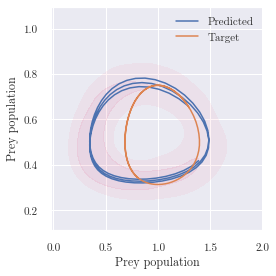

In [128]:
real_prey, real_pred = dataset.prey, dataset.predator
prey = lfm.likelihood(lfm.gp_model(t_predict))
predator = lfm(t_predict)

prey_mean = prey.mean.detach().squeeze()
predator_mean = predator.mean.detach().squeeze()
x_samples = softplus(prey.sample(torch.Size([50])).detach().squeeze())
y_samples = predator.sample(torch.Size([50])).detach().squeeze()

plot_phase(x_samples, y_samples,
           x_mean=softplus(prey_mean),
           y_mean=predator_mean,
           x_target=real_prey,
           y_target=real_pred)
plt.xlabel('Prey population')
plt.ylabel('Prey population')
plt.tight_layout()
# plt.savefig('phaseplot.pdf')

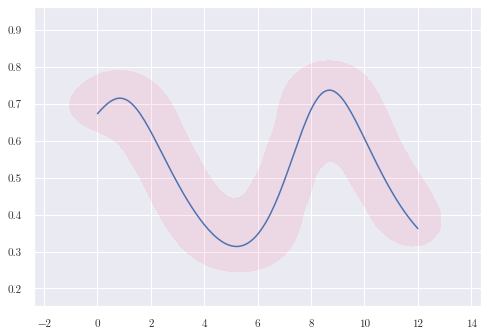

In [39]:
kdeplot(x=t_predict.repeat(50), y=y_samples.flatten(), fill=True, color='pink', alpha=0.1, levels=2, thresh=.1,)
plt.plot(t_predict, predator.mean.detach())